Code is modified from:
https://github.com/niconielsen32/NeuralNetworks/blob/main/transferLearning.ipynb


In [4]:
from PIL import Image

%cd ./FreshVsSpoiled/

im = Image.open('Fresh/test_20171016_104321D.jpg')
width, height = im.size
print(width, height)
%cd ..

/Users/mzs0153/Library/CloudStorage/Box-Box/Meat Classification/FreshVsSpoiled
1280 720
/Users/mzs0153/Library/CloudStorage/Box-Box/Meat Classification


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Preparing TensorFlow Dataset

Found 1896 files belonging to 2 classes.
Using 1328 files for training.
Found 1896 files belonging to 2 classes.
Using 568 files for validation.
Batches for testing --> tf.Tensor(9, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(9, shape=(), dtype=int64)
(32, 150, 150, 3)
(32,)


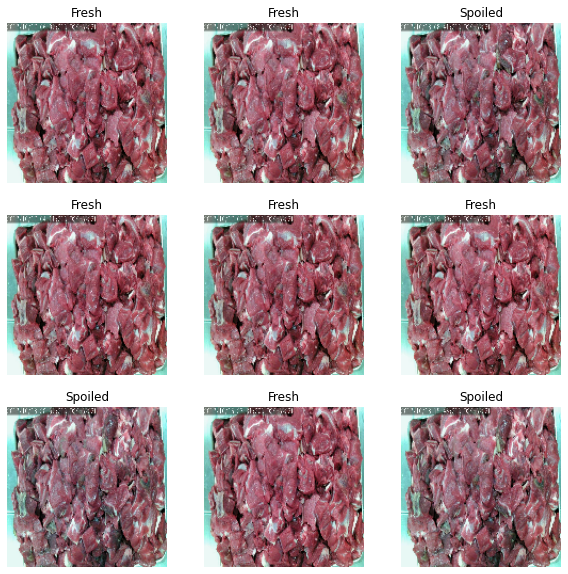

In [8]:
image_height = 150
image_width = 150
batch_size = 32

data_train= tf.keras.preprocessing.image_dataset_from_directory(
    'FreshVsSpoiled',
    labels='inferred',
    label_mode = "int",
    class_names = ['Fresh', 'Spoiled'],
    color_mode= 'rgb',
    batch_size=batch_size,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 57,
    validation_split = 0.30,
    subset = "training",
)


#data_train, info = tfds.load("horses_or_humans", with_info=True, split='train[:80%]')

data_valid = tf.keras.preprocessing.image_dataset_from_directory(
    'FreshVsSpoiled',
    labels='inferred',
    label_mode = "int",
    class_names = ['Fresh', 'Spoiled'],
    color_mode= 'rgb',
    batch_size=batch_size,
    image_size= (image_height, image_width),
    shuffle = True,
    seed = 57,
    validation_split = 0.30,
    subset = "validation",
)

data_test = data_valid.take(9)
data_valid = data_valid.skip(9)

print('Batches for testing -->', data_test.cardinality())
print('Batches for validating -->', data_valid.cardinality())

class_names = data_train.class_names

for image_batch, labels_batch in data_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data Augmentation

In [9]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Transfer Learning 

In [20]:
base_model=keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(image_height,image_width,3),
    include_top=False,
)

base_model.trainable=False

inputs = keras.Input(shape=(image_height, image_width, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#x= keras.layers.Dense(256,activation='relu')(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                           

# Training

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 3
model.fit(data_train, epochs=epochs, validation_data=data_valid)

Epoch 1/3
42/42 [==============================] - 57s 1s/step - loss: 0.5566 - binary_accuracy: 0.7011 - val_loss: 0.4363 - val_binary_accuracy: 0.7571
Epoch 2/3
42/42 [==============================] - 51s 1s/step - loss: 0.3202 - binary_accuracy: 0.8765 - val_loss: 0.3253 - val_binary_accuracy: 0.8214
Epoch 3/3
42/42 [==============================] - 48s 1s/step - loss: 0.2523 - binary_accuracy: 0.9134 - val_loss: 0.2859 - val_binary_accuracy: 0.8536


In [13]:
predictions = model.predict(data_test)

In [14]:
predictions

array([[0.03553349],
       [0.24614364],
       [0.92048085],
       [0.888799  ],
       [0.03198564],
       [0.27282298],
       [0.03692722],
       [0.9014931 ],
       [0.8156647 ],
       [0.9198994 ],
       [0.04655519],
       [0.0594624 ],
       [0.03945088],
       [0.01820391],
       [0.7875916 ],
       [0.90932477],
       [0.05907688],
       [0.02889886],
       [0.91315794],
       [0.05083245],
       [0.9026387 ],
       [0.41458648],
       [0.04067713],
       [0.9166225 ],
       [0.3824343 ],
       [0.03128925],
       [0.2760214 ],
       [0.03115731],
       [0.8622025 ],
       [0.04145399],
       [0.02831751],
       [0.03832164],
       [0.0417034 ],
       [0.02382252],
       [0.02933297],
       [0.03478563],
       [0.4894894 ],
       [0.8259257 ],
       [0.03486499],
       [0.06028607],
       [0.03808564],
       [0.80866814],
       [0.06746638],
       [0.03972667],
       [0.3985496 ],
       [0.91581523],
       [0.29860872],
       [0.042

#Testing Accuracy 

In [22]:
# Evaluate the best model with testing data.
print(model.evaluate(x=data_test))

9/9 [==============================] - 9s 950ms/step - loss: 0.2656 - binary_accuracy: 0.8715
[0.26557767391204834, 0.8715277910232544]


# Fine Tuning

In [26]:
# we start by unfreezing all layers of the base model
base_model.trainable = True

# Freeze all layers except the 10 last layers 
for layer in base_model.layers[:-10]: 
    layer.trainable = False

# compile and retrain with a low learning rate
low_lr = 10e-5
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=low_lr), 
              metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 3
history = model.fit(data_train, epochs=epochs,
                    validation_data=data_valid)

Epoch 1/3
42/42 [==============================] - 59s 1s/step - loss: 0.1296 - binary_accuracy: 0.9360 - val_loss: 0.0656 - val_binary_accuracy: 0.9750
Epoch 2/3
42/42 [==============================] - 54s 1s/step - loss: 0.1081 - binary_accuracy: 0.9601 - val_loss: 0.0926 - val_binary_accuracy: 0.9679
Epoch 3/3
42/42 [==============================] - 56s 1s/step - loss: 0.1112 - binary_accuracy: 0.9503 - val_loss: 0.0533 - val_binary_accuracy: 0.9750


#Testing Accuracy After Fine Tuning

In [27]:
# Evaluate the model with testing data after fine tuning
print(model.evaluate(x=data_test))

9/9 [==============================] - 9s 909ms/step - loss: 0.0484 - binary_accuracy: 0.9826
[0.04838467016816139, 0.9826388955116272]
